In [32]:
# !pip install dtreeviz

In [1]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import pandas as pd
import numpy as np
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

/home/sheba/anaconda3/envs/nlp/lib/python3.7/site-packages/fastbook/__init__.py:16: UserWarning: Missing Azure SDK - please run `pip install azure-cognitiveservices-search-imagesearch`
  warn("Missing Azure SDK - please run `pip install azure-cognitiveservices-search-imagesearch`")


# Tabular Data Approach

First load the same lsa data from the prior bag of words experimentation.

In [71]:
# X_train = pd.read_csv('title_lsa_X_train.csv', low_memory=False).drop(['Unnamed: 0'], 1)
# X_validation = pd.read_csv('title_lsa_X_test.csv', low_memory=False).drop(['Unnamed: 0'], 1)
# y_train = pd.read_csv('title_lsa_y_train.csv', low_memory=False).drop(['Unnamed: 0'], 1)
# y_validation = pd.read_csv('title_lsa_y_test.csv', low_memory=False).drop(['Unnamed: 0'],1)
train = pd.read_csv('title_lsa_train.csv', low_memory=False).drop(['Unnamed: 0'],1)
test = pd.read_csv('title_lsa_test.csv', low_memory=False).drop(['Unnamed: 0'],1)

# FastAI REALLY wants to do the train/validation splitting itself, so I have to re-merge the train and test...
df = pd.concat([train, test], ignore_index=True)

In [72]:
# print(f"X_train's shape: {X_train.shape}\nX_test's shape {X_validation.shape}\ny_train's shape {y_train.shape}\ny_test's shape {y_validation.shape}")

# print(train.shape, test.shape)
print(df.shape)

(5871, 921)


In [73]:
df.head(3)

,0,1,2,3,...,917,918,919,controversial
0,0.181259,-0.042566,-0.031585,-0.227923,...,0.000285,0.000577,0.001767,False
1,0.180734,-0.107807,-0.156737,0.084364,...,-0.007645,0.003584,0.022836,False
2,0.066126,0.320079,-0.130682,0.134803,...,-0.003189,-0.024748,-0.001777,True


In [8]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))  # can split randomly, no need to manage a time series

NameError: name 'df' is not defined

In [79]:
procs = []

In [3]:
dep_var='controversial'

In [82]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
print(len(cont), len(cat))

920 0


In [83]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [84]:
len(to.train),len(to.valid)

(4697, 1174)

In [85]:
to.show(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,controversial
5797,0.113039,0.006583,0.099840,-0.066631,-0.034320,-0.000455,-0.032183,-0.121753,-0.209270,-0.138687,0.147877,-0.017504,0.172392,-0.149438,0.010316,0.064402,-0.087789,-0.061534,0.061283,0.150376,0.094954,0.063010,-0.101681,-0.055174,-0.097452,-0.106211,-0.024306,-0.046437,0.009086,0.120081,-0.000409,-0.023311,-0.011505,0.032163,-0.067955,-0.039377,-0.001007,-0.006858,-0.022320,0.051942,-0.005216,0.023232,-0.056

In [99]:
import pickle
# file_pi = open('to.pkl', 'wb') 
# pickle.dump(to, file_pi)

file_pi = open('to.pkl','rb')
to = pickle.load(file_pi)

In [100]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [102]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

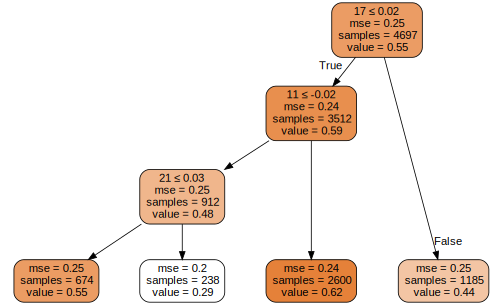

In [103]:
draw_tree(m, X_train, size=7, leaves_parallel=True, precision=2)

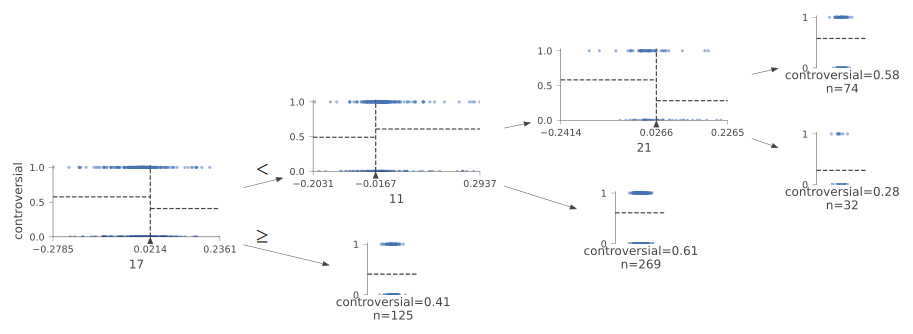

In [104]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [159]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [17]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [161]:
m_rmse(m, xs, y)

0.035055

In [162]:
m_rmse(m, valid_xs, valid_y)

0.591004

It's overfitting very very badly!

In [163]:
m.get_n_leaves(), len(xs)

(419, 4697)

The prior methods used accuracy, not r_mse, so let's re-run those measurements w accuracy.

In [16]:
def m_acc(m, xs, y): 
    y_pred = np.round(m.predict(xs),0)
    df = pd.DataFrame()
    df['y'] = y
    df['y_pred'] = y_pred
    correct = df.loc[df['y']==df['y_pred']]
    return ((correct.shape[0])/df.shape[0])

In [165]:
m_acc(m, xs, y)  # Only 99% accurate on the training set! No big deal...

0.9980838833297849

In [166]:
m_acc(m, valid_xs, valid_y)   # and 65% on validation. Not so bad

0.6490630323679727

Number of leaves is ok. So that's not why. But it's not doing great anyways, no better than the prior methods. Let's try a random forest using this FastAI method. We already tried this in the prior work but hey let's do that anyway. The code is available!

In [167]:
def rf(xs, y, n_estimators=40, max_samples=4697,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [168]:
m = rf(xs, y)

In [169]:
m

RandomForestRegressor(max_features=0.5, max_samples=4697, min_samples_leaf=5,
                      n_estimators=40, n_jobs=-1, oob_score=True)

In [170]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)  # rmse

(0.23398, 0.434701)

In [171]:
m_acc(m, xs, y), m_acc(m, valid_xs, valid_y)  # 71% is a new high!

(0.9968064722163082, 0.7112436115843271)

In [176]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [177]:
r_mse(preds.mean(0), valid_y)

0.434701

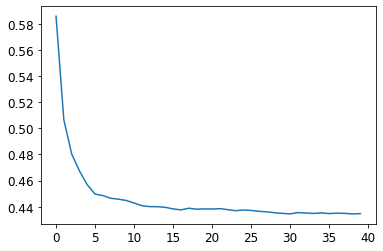

In [178]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [179]:
r_mse(m.oob_prediction_, y)

0.441104

In [181]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [182]:
preds.shape

(40, 1174)

In [186]:
preds_std = preds.std(0)
preds_std[:5]

array([0.41214366, 0.43004423, 0.31440483, 0.39254108, 0.18049405])

This is confidence.  Lower stdv means trees agree. Higher means they don't.

In [187]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [188]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
17,17,0.016303
25,25,0.009408
22,22,0.006498
6,6,0.005956
18,18,0.005275
21,21,0.004796
11,11,0.004250
34,34,0.004036
146,146,0.003642
73,73,0.003364


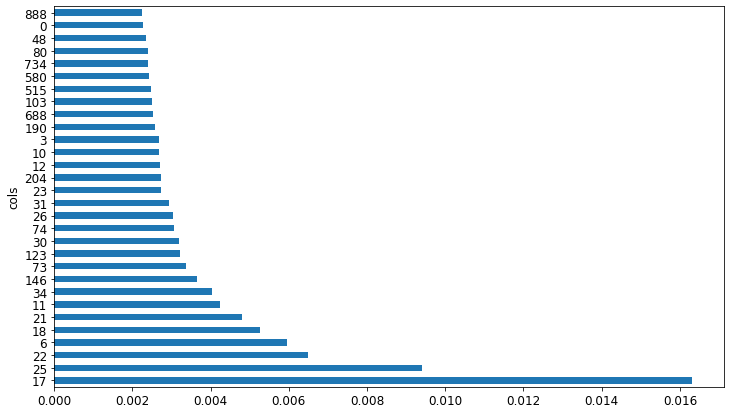

In [189]:


def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);



Unfortunately, I'm not sure how to actually see what 17 is referring to, as this is a value resulting from a dimensionality reduction using a TruncatedSVD. Which is a shame, as there are certainly some values that indicate a high likelihood of controversy.

In [191]:
fi.mean()

cols         inf
imp     0.001087
dtype: float64

In [192]:
fi.min()

cols              0
imp     1.98632e-05
dtype: object

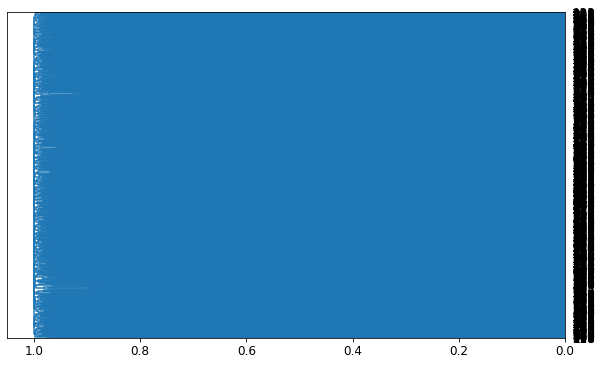

In [194]:
cluster_columns(xs)

 Clearly this chart is not useful with 920 columns.

# NN Tabular approach

In [2]:
train = pd.read_csv('title_lsa_train.csv', low_memory=False).drop(['Unnamed: 0'],1)
test = pd.read_csv('title_lsa_test.csv', low_memory=False).drop(['Unnamed: 0'],1)

# FastAI REALLY wants to do the train/validation splitting itself, so I have to re-merge the train and test...
df_nn_final = pd.concat([train, test], ignore_index=True)

In [3]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df_nn_final))

In [5]:
dep_var = "controversial"

In [6]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)
len(cont_nn), len(cat_nn)

(920, 0)

In [31]:
# cont_nn = [int(value) for value in cont_nn]

In [7]:
procs_nn = []
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names='controversial')

In [8]:
dls = to_nn.dataloaders(1024)

In [9]:
dls.show_batch()

In [10]:
y = to_nn.train.y
y.min(),y.max()

(0, 1)

In [11]:
from fastai.tabular.all import *

In [20]:
learn = tabular_learner(dls, metrics=accuracy)

In [24]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.010964781977236271)

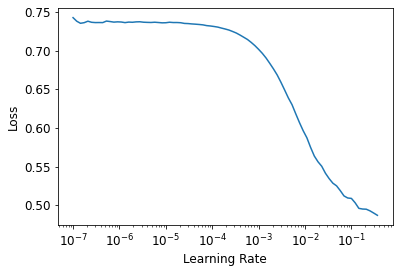

In [21]:
learn.lr_find()

In [22]:
learn.fit_one_cycle(20, 1e-2)  # find the steepest slope

epoch,train_loss,valid_loss,accuracy,time
0,0.721147,0.692302,0.553663,00:00
1,0.649241,0.689492,0.645656,00:00
2,0.557836,0.670270,0.554514,00:00
3,0.478478,0.655550,0.667802,00:00
4,0.408377,0.664110,0.590290,00:00
5,0.349427,0.678728,0.616695,00:00
6,0.299013,0.716489,0.547700,00:00
7,0.257265,0.657651,0.609029,00:00
8,0.221984,0.649010,0.626917,00:00
9,0.194398,0.637197,0.652470,00:00


Clearly overfitting on the training set after only the first couple epochs. Training acc achieved a peak of 71%, which is  the same as the last attempt.

In [23]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.680351

# NLP Approach

Using code from the FastAI textbook at https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb

In [1]:
# from IPython.display import display,HTML
# from fastai import *
from fastai.text.all import *
import pandas as pd

### Preprocessing

In [53]:
# First, load the original text dataset.
# df = pd.read_csv('top_and_controversial_lg.csv', index_col=0)
df = pd.read_csv('top_and_controversial_lg_1.csv', index_col=0).drop(['Unnamed: 0.1', 'Unnamed: 0.1.1', "Unnamed: 0.1.1.1"],1)

To make sure we have the same split of data as in the previous work, I have to add an is_valid column to the data, but have to first use sklearn's train_test_split to split it into separate dataframes, and reassemble. It's tedious, but the price I pay for not being smarter about saving these.

In [91]:
y = df['controversial']

# drop all columns except the word counts
X = df.drop(['controversial'],1)

In [92]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.2, 
                                                   random_state = 42,
                                                   stratify=y)
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

In [93]:
X_train = pd.read_csv('X_train.csv', index_col=0)
X_test=  pd.read_csv('X_test.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
y_test= pd.read_csv('y_test.csv', index_col=0)

In [127]:
X_train['controversial'] = y_train
X_train['is_valid'] = False
X_test['controversial'] = y_test
X_test['is_valid'] = True

In [128]:
df2 = pd.concat([X_train, X_test])

In [129]:
df2.columns

Index(['title', 'score', 'upvote_ratio', 'id', 'url', 'comms_num', 'created',
       'timestamp', 'char_count', 'word_count', 'char_count_quantile',
       'word_count_quantile', 'publisher', 'soup', 'p', 'titles_match',
       'sentiment', 'controversial', 'is_valid'],
      dtype='object')

In [130]:
df2.to_csv('top_and_controversial_lg_2.csv')

In [2]:
df2 = pd.read_csv('top_and_controversial_lg_2.csv', index_col=0)

In [3]:
df2.head()

,title,score,upvote_ratio,id,url,comms_num,created,timestamp,char_count,word_count,char_count_quantile,word_count_quantile,publisher,soup,p,titles_match,sentiment,controversial,is_valid
4096,"Car drives through dueling demonstrations between Black Lives Matter protesters, counter-protesters in Yorba Linda",107,0.81,j0k1er,https://abc7.com/yorba-linda-protest-breonna-taylor-protester-hit/6585266/,84,1.601207e+09,2020-09-27 12:35:56,114,14,"(112.0, 116.0]","(13.0, 14.0]",abc7.com,"\n<!DOCTYPE doctype html>\n\n<html lang=""en"">\n<head>\n<!-- ABCOTV | 115f537d128f | 2903 | 7343d4a5bda8cf1cd4bee689a7b074a1b10ec726 | Mon, 05 Oct 2020 21:21:42 GMT -->\n<script type=""text/javascript"">\n ;(function(){\n function gc(n){var r=document.cookie.match(""(^|;) ?""+n+""=([^;]*)(;|$)"");return r?r[2]:null}function sc(n){document.cookie=n}function smpl(n){var r=n/100;return!!r&&Math.random()<=r}var _nr=!1,_nrCookie=gc(""_nr"");null!==_nrCookie?""1""===_nrCookie&&(_nr=!0):smpl(100)?(_nr=!0,sc(""_nr=1; path=/"")):(_nr=!1,sc(""_nr=0; path=/""));;\n _nr && window.NREUM||...","[<p>WATCH<span class=""feature-watch-live""> <!-- -->VIDEOS</span></p>]",False,POSITIVE,False,False
4559,Dallas Police Chief Resigns in Wake of Policing Protests,478,0.95,iq3nbw,https://www.nytimes.com/2020/09/08/us/dallas-police-chief-resigns-renee-hall.html?smid=re-share,86,1.599775e+09,2020-09-10 22:49:58,56,9,"(55.0, 56.0]","(8.0, 9.0]",www.nytimes.com,"<!DOCTYPE html>\n\n<html class=""story"" lang=""en"" xmlns:og=""http://opengraphprotocol.org/schema/"">\n<head>\n<title data-rh=""true"">Dallas Police Chief Resigns in Wake of Policing Protests - The New York Times</title>\n<meta content=""en-US"" data-rh=""true"" itemprop=""inLanguage""/><meta content=""2020-09-08T22:44:04.000Z"" data-rh=""true"" property=""article:published""/><meta content=""2020-09-09T20:07:48.463Z"" data-rh=""true"" property=""article:modified""/><meta content=""en"" data-rh=""true"" http-equiv=""Content-Language""/><meta content=""noarchive"" data-rh=""true"" name=""robots""/><meta content=""1000000073303...","[<p>Advertisement</p>, <p>Supported by</p>, <p class=""css-1smgwul e1wiw3jv0"" id=""article-summary"">The chief, U. Reneé Hall, faced eroding support on the City Council stemming from the department’s handling of public protests over African-Americans and policing.</p>, <p class=""css-1nuro5j e1jsehar1"" itemprop=""author"" itemscope="""" itemtype=""http://schema.org/Person"">By<!-- --> <span class=""css-1baulvz last-byline"" itemprop=""name"">David Montgomery</span></p>, <p class=""css-158dogj evys1bk0"">AUSTIN, Texas — U. Reneé Hall, the police chief in Dallas, abruptly announced her resignation on Tuesda...",True,NEGATIVE,False,False
2049,NYC restaurants can soon add a Covid-19 surcharge to customers' bills,823,0.92,ivtlx9,https://www.cnn.com/2020/09/19/us/nyc-covid-restaurant-surcharge-trnd/index.html,221,1.600555e+09,2020-09-19 23:34:03,69,11,"(68.0, 69.0]","(10.0, 11.0]",www.cnn.com,"<!DOCTYPE html>\n<html class=""no-js""><head><meta content=""IE=edge,chrome=1"" http-equiv=""X-UA-Compatible""/><meta charset=""utf-8""/><meta content=""text/html"" http-equiv=""Content-Type""/><meta content=""width=device-width, initial-scale=1.0, minimum-scale=1.0"" name=""viewport""/><link href=""/optimizelyjs/131788053.js"" rel=""dns-prefetch""/><link href=""//tpc.googlesyndication.com"" rel=""dns-prefetch""/><link href=""//pagead2.googlesyndication.com"" rel=""dns-prefetch""/><link href=""//www.googletagservices.com"" rel=""dns-prefetch""/><link href=""//partner.googleadservices.com"" rel=""dns-prefetch""/><link href=""/...","[<p class=""metadata__byline""><span class=""metadata__byline__author"">By Ganesh Setty, CNN</span></p>, <p class=""metadata__show""></p>, <p class=""update-time"">Updated 3:56 PM ET, Sat September 19, 2020 <span class=""video__source top_source"" id=""js-pagetop_video_source""></span></p>, <p class=""zn-body__paragraph speakable""><cite class=""el-editorial-source""> (CNN)</cite><

Now with that handled On to the main course, training this puppy.

In [4]:
# first the language model
lm = DataBlock(blocks=TextBlock.from_df('title', is_lm=True),
                    get_x=ColReader('text'),
                    splitter=ColSplitter())

In [5]:
dls = lm.dataloaders(df2, bs=64, seq_len=72, valid_col='is_valid')
dls.show_batch(max_n=6)

/home/sheba/anaconda3/envs/nlp/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj italy sees 1 , xxrep 3 0 new cases for first time since xxmaj may – as it xxunk | xxmaj coronavirus outbreak | xxmaj the xxmaj guardian xxbos xxmaj daughters sue xxmaj calgary care facility after mother dies with xxunk in xxunk xxbos xxmaj dogs xxunk with xxunk two men in xxmaj connecticut with xxunk xxunk of marijuana xxbos xxmaj west xxmaj virginia man gets up to xxunk years","xxmaj italy sees 1 , xxrep 3 0 new cases for first time since xxmaj may – as it xxunk | xxmaj coronavirus outbreak | xxmaj the xxmaj guardian xxbos xxmaj daughters sue xxmaj calgary care facility after mother dies with xxunk in xxunk xxbos xxmaj dogs xxunk with xxunk two men in xxmaj connecticut with xxunk xxunk of marijuana xxbos xxmaj west xxmaj virginia man gets up to xxunk years in"
1,"xxunk , pilot said in recording xxbos xxmaj body - cam video in xxmaj george xxmaj floyd killing shows officer pulled gun , xxunk and xxunk xxmaj floyd multiple times without xxunk xxbos xxmaj for xxmaj prisoners in the xxmaj west , the xxmaj virus and the xxmaj wildfires xxmaj are xxmaj xxunk xxmaj threats xxbos xxmaj denver is under a winter storm watch two days after the city hit 101 degrees",", pilot said in recording xxbos xxmaj body - cam video in xxmaj george xxmaj floyd killing shows officer pulled gun , xxunk and xxunk xxmaj floyd multiple times without xxunk xxbos xxmaj for xxmaj prisoners in the xxmaj west , the xxmaj virus and the xxmaj wildfires xxmaj are xxmaj xxunk xxmaj threats xxbos xxmaj denver is under a winter storm watch two days after the city hit 101 degrees xxbos"
2,flights to xxmaj iran xxbos xxmaj coronavirus : rolls - xxunk slumps to record half - year loss of £ xxunk xxbos xxmaj xxunk xxunk in xxmaj georgia gets 40 years in prison for xxunk 150 girls xxbos xxmaj prosecutors xxunk ex - officer as xxunk in xxmaj floyd 's death xxbos xxmaj dozens protest against xxmaj china during xxup us xxup nba game xxbos xxmaj vietnam war hero who downed 7,to xxmaj iran xxbos xxmaj coronavirus : rolls - xxunk slumps to record half - year loss of £ xxunk xxbos xxmaj xxunk xxunk in xxmaj georgia gets 40 years in prison for xxunk 150 girls xxbos xxmaj prosecutors xxunk ex - officer as xxunk in xxmaj floyd 's death xxbos xxmaj dozens protest against xxmaj china during xxup us xxup nba game xxbos xxmaj vietnam war hero who downed 7 enemy
3,"$ 500 payouts xxbos xxmaj xxunk of xxmaj netflix 's ' tiger xxmaj king ' prompts sheriff to ask for leads in xxunk cold case xxbos xxmaj colorado xxunk urge halt of drug used in arrests xxbos xxmaj minnesota man trapped xxunk a xxunk tree for 4 days is rescued xxbos xxup xxunk xxmaj carolina law banning xxup lgbtq sex ed is unconstitutional , judge rules xxbos xxup nj xxmaj transit wants","500 payouts xxbos xxmaj xxunk of xxmaj netflix 's ' tiger xxmaj king ' prompts sheriff to ask for leads in xxunk cold case xxbos xxmaj colorado xxunk urge halt of drug used in arrests xxbos xxmaj minnesota man trapped xxunk a xxunk tree for 4 days is rescued xxbos xxup xxunk xxmaj carolina law banning xxup lgbtq sex ed is unconstitutional , judge rules xxbos xxup nj xxmaj transit wants to"
4,"becomes legal in xxmaj illinois on xxmaj new xxmaj years xxmaj day xxbos xxmaj judge xxmaj xxunk xxmaj xxunk , who gave xxmaj brock xxmaj turner xxunk sentence in rape case , recalled from office xxbos xxmaj hurricane xxmaj laura removed a xxmaj lake xxmaj charles xxmaj confederate monument , after parish officials voted to keep it xxbos xxmaj california xxunk a gay civil rights leader . xxmaj activists want clemency for","legal in xxmaj illinois on xxmaj new xxmaj years xxmaj day xxbos xxmaj judge xxmaj xxunk xxmaj xxunk , who gave xxmaj brock xxmaj turner xxunk sentence in rape case , recalled from office xxbos xxmaj hurricane xxmaj laura removed a xxmaj lake xxmaj charles xxmaj confederate monument , after parish officials voted to keep it xxbos xxmaj california xxunk a gay civil rights leader . xxmaj activists want clem

In [7]:
for idx, inputs in enumerate(dls.valid):
    print(idx, inputs)

0 (LMTensorText([[   2,    8, 4034,  ...,   84,    8,   55],
        [ 108,   12,    0,  ...,  164,    2,    8],
        [  65,   41, 3639,  ...,  143,  228, 1712],
        ...,
        [   8, 1178,    8,  ...,    8,  405,   71],
        [  59, 3313,   91,  ...,    9, 1217,  139],
        [  13,   19,    8,  ...,  790,  110,  457]], device='cuda:0'), tensor([[   8, 4034,    8,  ...,    8,   55,   10],
        [  12,    0,   14,  ...,    2,    8,   46],
        [  41, 3639,  141,  ...,  228, 1712,   51],
        ...,
        [1178,    8, 3522,  ...,  405,   71,    2],
        [3313,   91,   18,  ..., 1217,  139,   41],
        [  19,    8, 2236,  ...,  110,  457,   27]], device='cuda:0'))
1 (LMTensorText([[  10,    8,  235,  ...,  871,    8,  141],
        [  46, 2571,  529,  ...,    0,    2,    8],
        [  51,   45, 1454,  ...,  478,    8,  134],
        ...,
        [   2,    8,   93,  ...,    2,    8,    0],
        [  41, 2182,  136,  ...,    8, 3050,   10],
        [  27,    7, 

In [6]:
learn = language_model_learner(
    dls, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.10000000149011612)

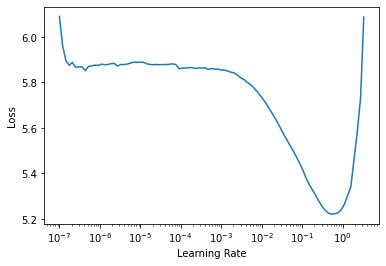

In [7]:
learn.lr_find()

In [8]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.803432,4.107635,0.320101,60.802780,00:04


So after only 1 epoch, it can predict the next work with 32% accuracy.

In [9]:
learn.save('1epoch-lm-2')

Path('models/1epoch-lm-2.pth')

In [10]:
learn = learn.load('1epoch-lm-2')

In [11]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.832251,3.923497,0.335728,50.577003,00:04
1,3.643496,3.750564,0.365450,42.545074,00:04
2,3.443263,3.632280,0.379749,37.798912,00:04
3,3.199594,3.623604,0.383676,37.472370,00:04
4,2.922885,3.566348,0.408800,35.387135,00:04
5,2.646796,3.553750,0.422176,34.944122,00:04
6,2.380290,3.599896,0.431800,36.594437,00:04
7,2.158418,3.591130,0.434617,36.275063,00:04
8,1.981636,3.614417,0.436544,37.129704,00:04
9,1.852694,3.617355,0.436761,37.238926,00:04


43.5% correct prediciton of the next word ain't so shabby! But we aren't actually interested in prediction of the next word. We want prediction of whether or not it is controversial.

In [12]:
learn.save_encoder('finetuned-lm-2')

In [13]:
title_class = DataBlock(blocks=(TextBlock.from_df('title', seq_len=72, vocab=dls.vocab), CategoryBlock),
                      get_x=ColReader('text'),
                      get_y=ColReader('controversial'),
                      splitter=ColSplitter())

In [14]:
dl_class = title_class.dataloaders(df2, bs=128, seq_len=72)

/home/sheba/anaconda3/envs/nlp/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [15]:
dl_class.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj infant among 3 fatally shot in south xxmaj kansas xxmaj city home . "" xxunk who have guns are going to use those guns for bad things . xxmaj and until we come to grips with that and start taking the guns out of the hands of people who should n’t have them , we ’re going to continue to have this . xxmaj it ’s just that xxunk . """,True
1,"xxbos xxmaj xxunk , xxmaj xxunk xxmaj say xxmaj they xxmaj have xxmaj xxunk 9 / 11 xxmaj was a ' lie ' — xxmaj new xxmaj york - xxmaj the group xxmaj xxunk and xxmaj xxunk for 9 / 11 xxmaj xxunk say they have xxunk evidence that xxunk the official story of the xxmaj september 11 , 2001 terrorist attacks was "" a lie ” and “ a fraud . ”",True
2,"xxbos ' no xxmaj drone xxmaj war . ' xxmaj thousands xxunk in protest outside xxmaj xxunk - xxmaj xxunk in rainbow peace xxunk and xxunk under xxunk , thousands of protesters xxunk in the xxunk xxmaj saturday outside xxmaj xxunk xxmaj air xxmaj base to demand the facility end its alleged support of xxup u.s . drone operations . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",True


In [16]:
learn = text_classifier_learner(dl_class, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

In [17]:
learn = learn.load_encoder('finetuned-lm-2')

In [18]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.000355,0.651824,0.629787,00:02


In [19]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.841594,0.641187,0.638298,00:02


In [20]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.682091,0.618884,0.662128,00:03


In [21]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.599995,0.612741,0.674043,00:03
1,0.574378,0.591361,0.690213,00:03
2,0.534689,0.583821,0.693617,00:03
3,0.503239,0.580007,0.706383,00:03
4,0.475418,0.576668,0.705532,00:03


Even this approach caps at about 71%.

In [22]:
learn.save('final-classifier-2')

Path('models/final-classifier-2.pth')

In [23]:
learn.export('final-classifier-2.pkl')

The next step is to deploy this and use it! 

https://medium.com/datadriveninvestor/fastai-and-render-quick-and-easy-way-to-create-and-deploy-computer-vision-models-14fd3f903cfc